In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
path_to_file = "kor-eng/kor.txt"

In [4]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # 단어와 단어 뒤에 오는 구두점(.)사이에 공백을 생성합니다.
  # 예시: "he is a boy." => "he is a boy ."
  # 참고:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # (a-z, A-Z, ".", "?", "!", ",")을 제외한 모든 것을 공백으로 대체합니다.
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서
  # 문장에 start와 end 토큰을 추가합니다.
  w = '<start> ' + w + ' <end>'
  return w

def preprocess_sentence_kr(w):
  w = w.strip()

  # 단어와 단어 뒤에 오는 구두점(.)사이에 공백을 생성합니다.
  # 예시: "he is a boy." => "he is a boy ."
  # 참고:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  w = re.sub(r'[ |ㄱ-ㅎ|ㅏ-ㅣ]+', " ", w)

  w = w.strip()

  # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서
  # 문장에 start와 end 토큰을 추가합니다.
  w = '<start> ' + w + ' <end>'
  return w

In [5]:
en_sentence = u"May I borrow this book?"
ko_sentence = u"너는 누구니?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence_kr(ko_sentence))

<start> may i borrow this book ? <end>
<start> 너는 누구니 ? <end>


In [6]:
# 1. 문장에 있는 억양을 제거합니다.
# 2. 불필요한 문자를 제거하여 문장을 정리합니다.
# 3. 다음과 같은 형식으로 문장의 쌍을 반환합니다: [영어, 한글]

def create_dataset(path, num_examples):
  data = pd.read_csv(path, delimiter = "\t")
  data.columns = ["en", "kor", "cc"]
  en = [preprocess_sentence(l) for l in data['en'][:num_examples]]
  kr = [preprocess_sentence_kr(l) for l in data['kor'][:num_examples]]

  # 다음과 같은 형식으로 문장의 쌍을 반환합니다: [영어, 한국어]
  return en, kr # 이렇게 하면 한->영 번역이 됨

In [7]:
en, kor = create_dataset(path_to_file, None)
print(en[-1])
print(kor[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> 의심의 여지 없이 세상에는 어떤 남자이든 정확히 딱 알맞는 여자와 결혼하거나 그 반대의 상황이 존재하지 . 그런데 인간이 수백 명의 사람만 알고 지내는 사이가 될 기회를 갖는다고 생각해 보면 , 또 그 수백 명 중 열여 명 쯤 이하만 잘 알 수 있고 , 그리고 나서 그 열여 명 중에 한두 명만 친구가 될 수 있다면 , 그리고 또 만일 우리가 이 세상에 살고 있는 수백만 명의 사람들만 기억하고 있다면 , 딱 맞는 남자는 지구가 생겨난 이래로 딱 맞는 여자를 단 한번도 만난 적이 없을 수도 있을 거라는 사실을 쉽게 눈치챌 수 있을 거야 . <end>


In [8]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer


In [9]:
def load_dataset(path, num_examples=None):
  # 전처리된 타겟 문장과 입력 문장 쌍을 생성합니다.
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [10]:
# 언어 데이터셋을 아래의 크기로 제한하여 훈련과 검증을 수행합니다.
num_examples = 3700
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 타겟 텐서와 입력 텐서의 최대 길이를 계산합니다.
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ, max_length_inp)

19 17


In [11]:
# 훈련 집합과 검증 집합을 80대 20으로 분리합니다.
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 훈련 집합과 검증 집합의 데이터 크기를 출력합니다.
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

2960 2960 740 740


In [12]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [13]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
24 ----> 너
144 ----> 진짜
89 ----> 우리가
799 ----> 도울
12 ----> 수
67 ----> 있을
190 ----> 거라고
74 ----> 생각해
4 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
17 ----> do
7 ----> you
61 ----> really
32 ----> think
31 ----> we
30 ----> can
74 ----> help
8 ----> ?
2 ----> <end>


In [14]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)

print(vocab_inp_size, vocab_tar_size)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

5490 2448


In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 17]), TensorShape([64, 19]))

In [16]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 샘플 입력
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 17, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # 쿼리 은닉 상태(query hidden state)는 (batch_size, hidden size)쌍으로 이루어져 있습니다.
    # query_with_time_axis은 (batch_size, 1, hidden size)쌍으로 이루어져 있습니다.
    # values는 (batch_size, max_len, hidden size)쌍으로 이루어져 있습니다.
    # 스코어(score)계산을 위해 덧셈을 수행하고자 시간 축을 확장하여 아래의 과정을 수행합니다.
    query_with_time_axis = tf.expand_dims(query, 1)

    # score는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
    # score를 self.V에 적용하기 때문에 마지막 축에 1을 얻습니다.
    # self.V에 적용하기 전에 텐서는 (batch_size, max_length, units)쌍으로 이루어져 있습니다.
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다. 
    attention_weights = tf.nn.softmax(score, axis=1)

    # 덧셈이후 컨텍스트 벡터(context_vector)는 (batch_size, hidden_size)쌍으로 이루어져 있습니다.
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [19]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 17, 1)


In [20]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # 어텐션을 사용합니다.
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output는 (batch_size, max_length, hidden_size)쌍으로 이루어져 있습니다.
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # 임베딩층을 통과한 후 x는 (batch_size, 1, embedding_dim)쌍으로 이루어져 있습니다.
    x = self.embedding(x)

    # 컨텍스트 벡터와 임베딩 결과를 결합한 이후 x의 형태는 (batch_size, 1, embedding_dim + hidden_size)쌍으로 이루어져 있습니다.
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 위에서 결합된 벡터를 GRU에 전달합니다.
    output, state = self.gru(x)

    # output은 (batch_size * 1, hidden_size)쌍으로 이루어져 있습니다.
    output = tf.reshape(output, (-1, output.shape[2]))

    # output은 (batch_size, vocab)쌍으로 이루어져 있습니다.
    x = self.fc(output)

    return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2448)


In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [24]:
# @tf.function
# def train_step(inp, targ, enc_hidden):
#   loss = 0

#   with tf.GradientTape() as tape:
#     enc_output, enc_hidden = encoder(inp, enc_hidden)

#     dec_hidden = enc_hidden

#     dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

#     # 교사 강요(teacher forcing) - 다음 입력으로 타겟을 피딩(feeding)합니다.
#     for t in range(1, targ.shape[1]):
#       # enc_output를 디코더에 전달합니다.
#       predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

#       loss += loss_function(targ[:, t], predictions)

#       # 교사 강요(teacher forcing)를 사용합니다.
#       dec_input = tf.expand_dims(targ[:, t], 1)

#   batch_loss = (loss / int(targ.shape[1]))

#   variables = encoder.trainable_variables + decoder.trainable_variables

#   gradients = tape.gradient(loss, variables)

#   optimizer.apply_gradients(zip(gradients, variables))

#   return batch_loss

In [25]:
# EPOCHS = 10

# for epoch in range(EPOCHS):
#   start = time.time()

#   enc_hidden = encoder.initialize_hidden_state()
#   total_loss = 0

#   for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
#     batch_loss = train_step(inp, targ, enc_hidden)
#     total_loss += batch_loss

#     if batch % 100 == 0:
#       print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
#                                                    batch,
#                                                    batch_loss.numpy()))
#   # 에포크가 2번 실행될때마다 모델 저장 (체크포인트)
#   if (epoch + 1) % 2 == 0:
#     checkpoint.save(file_prefix = checkpoint_prefix)

#   print('Epoch {} Loss {:.4f}'.format(epoch + 1,
#                                       total_loss / steps_per_epoch))
#   print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [26]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence_kr(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # 나중에 어텐션 가중치를 시각화하기 위해 어텐션 가중치를 저장합니다.
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # 예측된 ID를 모델에 다시 피드합니다.
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [27]:
# 어텐션 가중치를 그리기 위한 함수입니다.
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [28]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [29]:
# checkpoint_dir내에 있는 최근 체크포인트(checkpoint)를 복원합니다.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

print(tf.train.latest_checkpoint(checkpoint_dir))

./training_checkpoints\ckpt-2


In [30]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

Input: <start> 계속 시도해 . <end>
Predicted translation: keep trying . <end> 


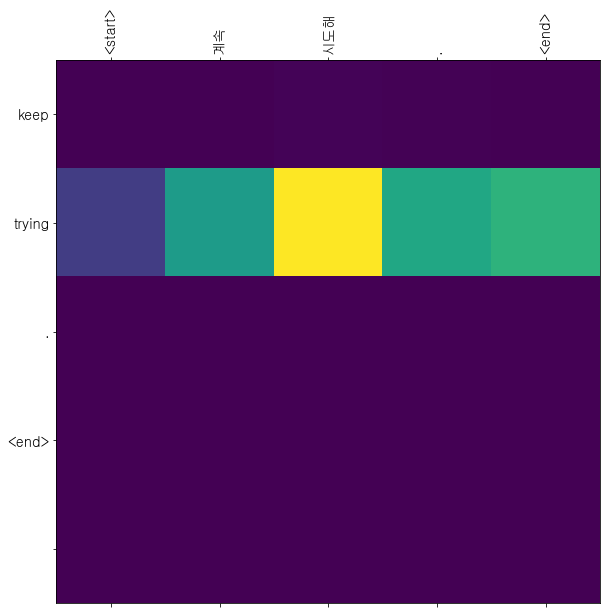

In [32]:
translate('계속 시도해.')